In [ ]:
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
import random
from tqdm import tqdm

def perform_random_walks(graph, num_walks, walk_length, seed=20):
    random.seed(seed)
    walks = []
    
    for _ in tqdm(range(num_walks), desc="Performing walks", unit="walk"):
        for starting_node in graph.nodes():
            walk = [starting_node]
            while len(walk) < walk_length:
                current_node = walk[-1]
                neighbors = list(graph.neighbors(current_node))
                if not neighbors:
                    break
                
                weights = [graph[current_node][neighbor]['weight'] for neighbor in neighbors]
                total_weight = sum(weights)
                probabilities = [weight / total_weight for weight in weights]
                
                next_node = np.random.choice(neighbors, p=probabilities)
                walk.append(next_node)
            walks.append(walk)
    
    return walks

def analyze_communities(seed, model=None):
    walks = perform_random_walks(G, num_walks=72, walk_length=6, seed=seed)
    walks = [[str(node) for node in walk] for walk in walks]
    model = Word2Vec(sentences=walks, vector_size=128, window=3, min_count=1, sg=1, workers=12, epochs=16)
    node_embeddings = np.array([model.wv[str(node)] for node in G.nodes()])

    kmeans = KMeans(n_clusters=10, random_state=seed)
    communities = kmeans.fit_predict(node_embeddings)

    community_dict = {}
    for node, community in zip(G.nodes(), communities):
        node_name = code_to_name.get(int(node), "Unknown")
        if community not in community_dict:
            community_dict[community] = []
        community_dict[community].append(node_name)

    with open(f"community_summary_seed_{seed}.txt", "w", encoding='EUC-KR') as file:
        for community, names in community_dict.items():
            file.write(f"Community {community}: {names}\n")

    with open(f"community_mapping_seed_{seed}.txt", "w", encoding='EUC-KR') as file:
        for node, community in zip(G.nodes(), communities):
            file.write(f"{node} : {community}\n")

data_df = pd.read_csv('all_collected_data.csv', encoding="EUC-KR")
edges = data_df[["출발 행정동 코드", "도착 행정동 코드", "이동인구(합)"]]

G = nx.Graph()
for index, row in edges.iterrows():
    if pd.notna(row["이동인구(합)"]):
        G.add_edge(
            int(row["출발 행정동 코드"]), int(row["도착 행정동 코드"]), weight=float(row["이동인구(합)"])
        )

df = pd.read_excel('data/서울생활이동데이터_자치구코드_20210907.xlsx')
code_to_name = df.set_index('시군구')['name'].to_dict()

for seed in [336, 500, 600]:
    analyze_communities(seed)


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.manifold import TSNE

plt.rc("font", family="Malgun Gothic")


def visualize_similarities(model, target_node, node_list, code_to_name):
    target_embedding = model.wv[str(target_node)]
    embeddings = np.array([model.wv[str(node)] for node in node_list])

    similarities = cosine_similarity([target_embedding], embeddings)[0]

    top_indices = np.argsort(-similarities)[:15]
    top_similarities = similarities[top_indices]
    top_nodes = [node_list[i] for i in top_indices]

    top_node_names = [code_to_name.get(node, "Unknown") for node in top_nodes]

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        [top_similarities],
        annot=True,
        cmap="coolwarm",
        xticklabels=top_node_names,
        yticklabels=["Similarity"],
    )
    plt.title(
        f'Top 12 Cosine Similarities with {code_to_name.get(target_node, "김포시")}'
    )
    plt.show()


def visualize_xy(model, node_list, code_to_name, highlight_node):
    embeddings = np.array([model.wv[str(node)] for node in node_list])

    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 10))
    for i, node in enumerate(node_list):
        color = "black"
        if int(node) < 12000:
            color = "blue"
        elif 31000 < int(node) < 32000:
            color = "green"
        elif 23000 < int(node) < 24000:
            color = "purple"

        if node == highlight_node:
            plt.scatter(
                reduced_embeddings[i, 0],
                reduced_embeddings[i, 1],
                color="red",
                s=100,
                edgecolors="gold",
                linewidth=2,
                label=code_to_name.get(node, "Unknown"),
            )
        else:
            plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=color)

    for i, node in enumerate(node_list):
        color = "black"
        if int(node) < 12000:
            color = "blue"
        elif 31000 < int(node) < 32000:
            color = "green"
        elif 23000 < int(node) < 24000:
            color = "purple"

        if node == highlight_node:
            plt.annotate(
                code_to_name.get(node, "Unknown"),
                xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                xytext=(5, 2),
                textcoords="offset points",
                ha="right",
                va="bottom",
                color="red",
                fontsize=12,
                fontweight="bold",
            )
        else:
            plt.annotate(
                code_to_name.get(node, "Unknown"),
                xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
                xytext=(5, 2),
                textcoords="offset points",
                ha="right",
                va="bottom",
                color=color,
            )

    plt.title("2D Visualization of Node Embeddings")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

Performing walks: 100%|██████████| 4096/4096 [01:06<00:00, 61.53walk/s]
c:\Users\kctco\anaconda3\envs\gis\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


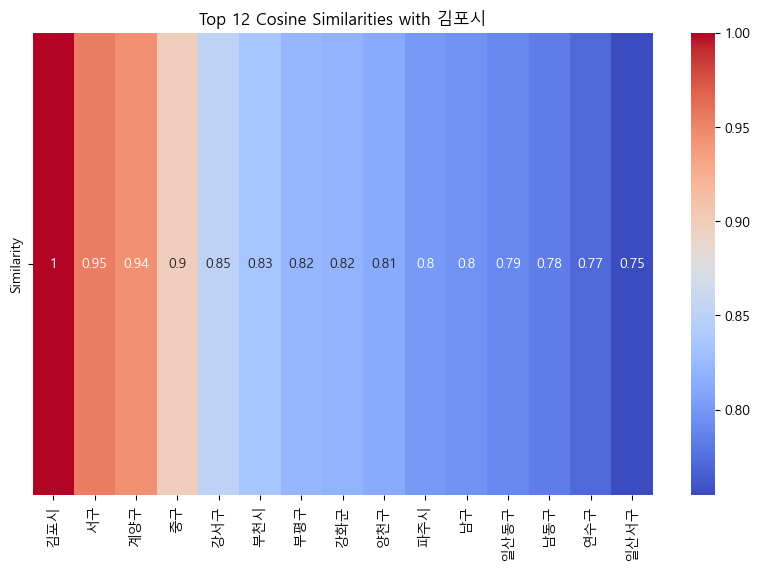

In [46]:
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

def perform_random_walks(graph, num_walks, walk_length, seed=20):
    random.seed(seed)
    walks = []
    for _ in tqdm(range(num_walks), desc="Performing walks", unit="walk"):
        for starting_node in graph.nodes():
            walk = [starting_node]
            while len(walk) < walk_length:
                current_node = walk[-1]
                neighbors = list(graph.neighbors(current_node))
                if not neighbors:
                    break
                weights = [graph[current_node][neighbor]['weight'] for neighbor in neighbors]
                total_weight = sum(weights)
                probabilities = [weight / total_weight for weight in weights]
                next_node = np.random.choice(neighbors, p=probabilities)
                walk.append(next_node)
            walks.append(walk)
    return walks

def analyze_communities(seed):
    walks = perform_random_walks(G, num_walks=16384, walk_length=6, seed=seed)
    walks = [[str(node) for node in walk] for walk in walks]
    model = Word2Vec(sentences=walks, vector_size=128, window=3, min_count=1, sg=1, workers=12, epochs=16)
    node_embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
    kmeans = KMeans(n_clusters=10, random_state=seed)
    communities = kmeans.fit_predict(node_embeddings)
    return model

data_df = pd.read_csv('all_collected_data.csv', encoding="EUC-KR")
edges = data_df[["출발 행정동 코드", "도착 행정동 코드", "이동인구(합)"]]
G = nx.Graph()
for index, row in edges.iterrows():
    if pd.notna(row["이동인구(합)"]):
        G.add_edge(int(row["출발 행정동 코드"]), int(row["도착 행정동 코드"]), weight=float(row["이동인구(합)"]))

df = pd.read_excel('data/서울생활이동데이터_자치구코드_20210907.xlsx')
code_to_name = df.set_index('시군구')['name'].to_dict()

model = analyze_communities(336)
visualize_similarities(model, '31230', list(G.nodes()), code_to_name)


c:\Users\kctco\anaconda3\envs\gis\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


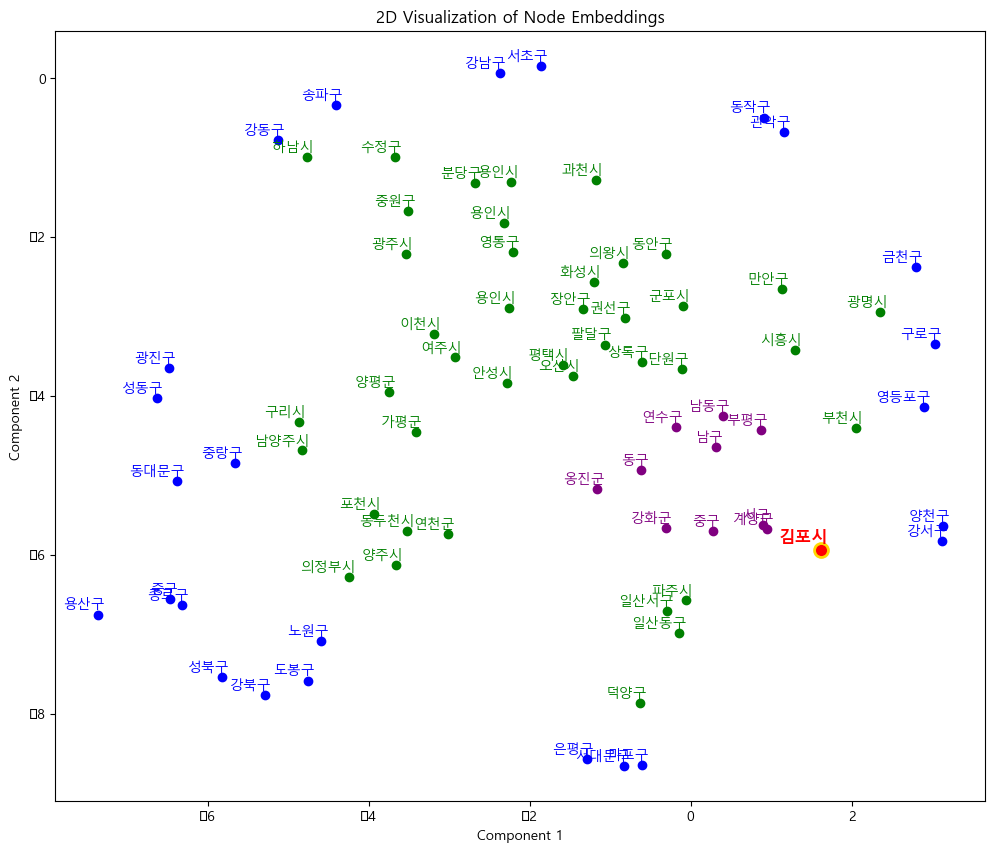

In [47]:
visualize_xy(model, list(G.nodes()), code_to_name, 31230)